# PSDL Streaming Mode Demo

## Real-Time Clinical Event Processing

---

PSDL supports two execution modes:
- **Batch Mode**: Evaluate a patient at a specific point in time (see `PSDL_Demo.ipynb`)
- **Streaming Mode**: Process clinical events as they arrive in real-time

This notebook demonstrates streaming mode using PSDL's temporal operators to detect clinical conditions as events flow through the system.

---

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

from datetime import datetime, timedelta

# PSDL Streaming imports
from reference.python.execution.streaming.models import ClinicalEvent, TrendResult, Severity
from reference.python.execution.streaming.operators import (
    DeltaWindowFunction, 
    SlopeWindowFunction,
    LastProcessFunction,
    EMAProcessFunction,
    MinWindowFunction,
    MaxWindowFunction
)

print("PSDL Streaming Demo Ready!")
print("\nAvailable Operators:")
print("  Window Functions (require event history):")
print("    - DeltaWindowFunction: delta(signal, window)")
print("    - SlopeWindowFunction: slope(signal, window)")
print("    - MinWindowFunction: min(signal, window)")
print("    - MaxWindowFunction: max(signal, window)")
print("\n  Process Functions (stateful, event-by-event):")
print("    - LastProcessFunction: last(signal)")
print("    - EMAProcessFunction: ema(signal, window)")

PyFlink not installed. Install with: pip install apache-flink>=1.18


PSDL Streaming Demo Ready!

Available Operators:
  Window Functions (require event history):
    - DeltaWindowFunction: delta(signal, window)
    - SlopeWindowFunction: slope(signal, window)
    - MinWindowFunction: min(signal, window)
    - MaxWindowFunction: max(signal, window)

  Process Functions (stateful, event-by-event):
    - LastProcessFunction: last(signal)
    - EMAProcessFunction: ema(signal, window)


---

## 2. Simulated Event Stream

We simulate a patient developing **Acute Kidney Injury (AKI)** over 48 hours.

The creatinine rises gradually from a normal baseline (1.0 mg/dL) to critical levels (4.2 mg/dL).

In [2]:
# Create simulated patient event stream
patient_id = "DEMO_001"
base_time = datetime(2024, 1, 15, 8, 0, 0)

# Simulate creatinine events over 48 hours (patient developing AKI)
creatinine_events = [
    ClinicalEvent(patient_id=patient_id, timestamp=base_time, signal_type="Cr", value=1.0, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=6), signal_type="Cr", value=1.1, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=12), signal_type="Cr", value=1.3, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=18), signal_type="Cr", value=1.5, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=24), signal_type="Cr", value=1.8, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=30), signal_type="Cr", value=2.2, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=36), signal_type="Cr", value=2.8, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=42), signal_type="Cr", value=3.5, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=48), signal_type="Cr", value=4.2, unit="mg/dL", source="lab"),
]

print("=== Simulated Patient Event Stream ===")
print(f"Patient: {patient_id}")
print(f"Scenario: AKI developing over 48 hours\n")
print("Time (h)  | Creatinine | Change from Baseline")
print("-" * 50)
for i, event in enumerate(creatinine_events):
    hours = (event.timestamp - base_time).total_seconds() / 3600
    change = event.value - creatinine_events[0].value
    status = "baseline" if i == 0 else f"+{change:.1f} mg/dL"
    print(f"  {hours:5.0f}h   |   {event.value:.1f} mg/dL  | {status}")

=== Simulated Patient Event Stream ===
Patient: DEMO_001
Scenario: AKI developing over 48 hours

Time (h)  | Creatinine | Change from Baseline
--------------------------------------------------
      0h   |   1.0 mg/dL  | baseline
      6h   |   1.1 mg/dL  | +0.1 mg/dL
     12h   |   1.3 mg/dL  | +0.3 mg/dL
     18h   |   1.5 mg/dL  | +0.5 mg/dL
     24h   |   1.8 mg/dL  | +0.8 mg/dL
     30h   |   2.2 mg/dL  | +1.2 mg/dL
     36h   |   2.8 mg/dL  | +1.8 mg/dL
     42h   |   3.5 mg/dL  | +2.5 mg/dL
     48h   |   4.2 mg/dL  | +3.2 mg/dL


---

## 3. Configure Streaming Operators

We set up operators matching the PSDL AKI detection scenario:

```yaml
trends:
  cr_rise_48h:
    expr: delta(Cr, 48h) >= 0.3   # KDIGO Stage 1
  cr_elevated:
    expr: last(Cr) >= 4.0          # KDIGO Stage 3
```

In [3]:
# Create operators matching PSDL scenario

# delta(Cr, 48h) >= 0.3 -> AKI Stage 1 (KDIGO criteria)
delta_48h = DeltaWindowFunction(
    trend_name="cr_rise_48h",
    threshold=0.3,
    comparison=">=",
    description="Creatinine rise >= 0.3 mg/dL in 48h (KDIGO Stage 1)"
)

# last(Cr) >= 4.0 -> AKI Stage 3 (absolute threshold)
cr_elevated = LastProcessFunction(
    trend_name="cr_elevated", 
    threshold=4.0,
    comparison=">=",
    description="Creatinine >= 4.0 mg/dL (KDIGO Stage 3)"
)

# slope(Cr, 24h) > 0 -> Rising trend
slope_24h = SlopeWindowFunction(
    trend_name="cr_rising_trend",
    threshold=0.0,
    comparison=">",
    description="Creatinine trend rising (slope > 0)"
)

print("Configured Streaming Operators:")
print(f"  1. {delta_48h.trend_name}: {delta_48h.description}")
print(f"  2. {cr_elevated.trend_name}: {cr_elevated.description}")
print(f"  3. {slope_24h.trend_name}: {slope_24h.description}")

Configured Streaming Operators:
  1. cr_rise_48h: Creatinine rise >= 0.3 mg/dL in 48h (KDIGO Stage 1)
  2. cr_elevated: Creatinine >= 4.0 mg/dL (KDIGO Stage 3)
  3. cr_rising_trend: Creatinine trend rising (slope > 0)


---

## 4. Process Events in Real-Time

Now we simulate real-time processing, evaluating each event as it "arrives".

This demonstrates how PSDL streaming operators:
1. Maintain state across events
2. Compute temporal functions (delta, slope) over sliding windows
3. Fire alerts when thresholds are crossed

In [4]:
print("=== Streaming Evaluation (Event-by-Event) ===")
print("\nProcessing events through PSDL streaming operators...\n")

# Track state for stateful operators
cr_elevated_state = {}
alerts_fired = []

print(f"{'Time':>6} | {'Cr':>6} | {'Delta':>7} | {'Slope':>8} | Alert")
print("-" * 60)

# Process each event as it "arrives"
for i, event in enumerate(creatinine_events):
    hours = (event.timestamp - base_time).total_seconds() / 3600
    
    # 1. Check last(Cr) >= 4.0 (stateful process function)
    cr_result, cr_elevated_state = cr_elevated.process_element(event, cr_elevated_state)
    
    # 2. Check delta(Cr, 48h) >= 0.3 (window function)
    window_start = event.timestamp - timedelta(hours=48)
    events_in_window = [e for e in creatinine_events[:i+1] if e.timestamp >= window_start]
    
    delta_result = delta_48h.process(
        patient_id=patient_id,
        events=events_in_window,
        window_start=window_start,
        window_end=event.timestamp
    )
    
    # 3. Check slope(Cr, 24h) > 0 (window function)
    window_start_24h = event.timestamp - timedelta(hours=24)
    events_24h = [e for e in creatinine_events[:i+1] if e.timestamp >= window_start_24h]
    
    slope_result = slope_24h.process(
        patient_id=patient_id,
        events=events_24h,
        window_start=window_start_24h,
        window_end=event.timestamp
    )
    
    # Determine alerts
    alert_msg = ""
    
    if delta_result.result and not any(a.get('type') == 'stage1' for a in alerts_fired):
        alert_msg = "AKI STAGE 1"
        alerts_fired.append({'type': 'stage1', 'time': hours, 'value': event.value, 'delta': delta_result.value})
    
    if cr_result.result and not any(a.get('type') == 'stage3' for a in alerts_fired):
        alert_msg = "AKI STAGE 3"
        alerts_fired.append({'type': 'stage3', 'time': hours, 'value': event.value})
    
    # Format output
    delta_str = f"{delta_result.value:+.2f}" if delta_result.value != 0 else "  0.00"
    slope_str = f"{slope_result.value:+.2f}/h" if len(events_24h) > 1 else "   n/a"
    
    print(f"{hours:5.0f}h | {event.value:5.1f}  | {delta_str:>7} | {slope_str:>8} | {alert_msg}")

=== Streaming Evaluation (Event-by-Event) ===

Processing events through PSDL streaming operators...

  Time |     Cr |   Delta |    Slope | Alert
------------------------------------------------------------
    0h |   1.0  |    0.00 |      n/a | 
    6h |   1.1  |   +0.10 |  +0.02/h | 
   12h |   1.3  |   +0.30 |  +0.03/h | AKI STAGE 1
   18h |   1.5  |   +0.50 |  +0.03/h | 
   24h |   1.8  |   +0.80 |  +0.03/h | 
   30h |   2.2  |   +1.20 |  +0.04/h | 
   36h |   2.8  |   +1.80 |  +0.06/h | 
   42h |   3.5  |   +2.50 |  +0.08/h | 
   48h |   4.2  |   +3.20 |  +0.10/h | AKI STAGE 3


---

## 5. Alert Summary

In [5]:
print("=== Alert Summary ===")
print(f"\nTotal events processed: {len(creatinine_events)}")
print(f"Alerts fired: {len(alerts_fired)}")
print("\nAlert Timeline:")
for alert in alerts_fired:
    if alert['type'] == 'stage1':
        print(f"  [{alert['time']:.0f}h] AKI STAGE 1 - Cr rise of {alert['delta']:.2f} mg/dL detected")
    elif alert['type'] == 'stage3':
        print(f"  [{alert['time']:.0f}h] AKI STAGE 3 - Cr >= 4.0 mg/dL (value: {alert['value']:.1f})")

print("\n" + "="*50)
print("Key Insight: Streaming mode detected AKI Stage 1 at 12h,")
print("giving clinicians 36 hours of warning before Stage 3.")
print("="*50)

=== Alert Summary ===

Total events processed: 9
Alerts fired: 2

Alert Timeline:
  [12h] AKI STAGE 1 - Cr rise of 0.30 mg/dL detected
  [48h] AKI STAGE 3 - Cr >= 4.0 mg/dL (value: 4.2)

Key Insight: Streaming mode detected AKI Stage 1 at 12h,
giving clinicians 36 hours of warning before Stage 3.


---

## 6. Visualize the Timeline

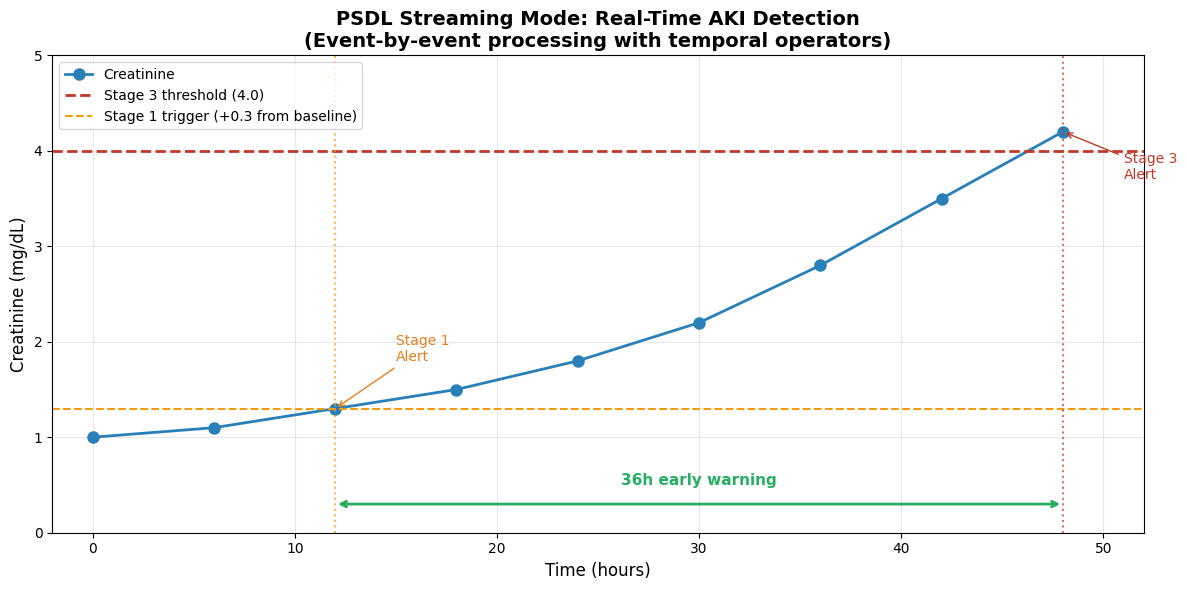

Chart saved to docs/assets/streaming_aki_detection.png


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract data for plotting
hours_list = [(e.timestamp - base_time).total_seconds() / 3600 for e in creatinine_events]
cr_values = [e.value for e in creatinine_events]

fig, ax = plt.subplots(figsize=(12, 6))

# Plot creatinine values
ax.plot(hours_list, cr_values, 'o-', color='#2980b9', linewidth=2, markersize=8, label='Creatinine')

# Add threshold lines
ax.axhline(y=4.0, color='#c0392b', linestyle='--', linewidth=2, label='Stage 3 threshold (4.0)')
ax.axhline(y=1.3, color='#f39c12', linestyle='--', linewidth=1.5, label='Stage 1 trigger (+0.3 from baseline)')

# Mark alert points
for alert in alerts_fired:
    if alert['type'] == 'stage1':
        ax.axvline(x=alert['time'], color='#f39c12', linestyle=':', alpha=0.7)
        ax.annotate('Stage 1\nAlert', xy=(alert['time'], alert['value']), 
                   xytext=(alert['time']+3, alert['value']+0.5),
                   fontsize=10, color='#e67e22',
                   arrowprops=dict(arrowstyle='->', color='#e67e22'))
    elif alert['type'] == 'stage3':
        ax.axvline(x=alert['time'], color='#c0392b', linestyle=':', alpha=0.7)
        ax.annotate('Stage 3\nAlert', xy=(alert['time'], alert['value']), 
                   xytext=(alert['time']+3, alert['value']-0.5),
                   fontsize=10, color='#c0392b',
                   arrowprops=dict(arrowstyle='->', color='#c0392b'))

# Styling
ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Creatinine (mg/dL)', fontsize=12)
ax.set_title('PSDL Streaming Mode: Real-Time AKI Detection\n(Event-by-event processing with temporal operators)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-2, 52)
ax.set_ylim(0, 5)

# Add early warning annotation
if len(alerts_fired) >= 2:
    early_warning = alerts_fired[1]['time'] - alerts_fired[0]['time']
    ax.annotate(f'{early_warning:.0f}h early warning', 
               xy=(alerts_fired[0]['time'] + early_warning/2, 0.5),
               fontsize=11, ha='center', color='#27ae60', fontweight='bold')
    ax.annotate('', xy=(alerts_fired[0]['time'], 0.3), xytext=(alerts_fired[1]['time'], 0.3),
               arrowprops=dict(arrowstyle='<->', color='#27ae60', lw=2))

plt.tight_layout()
plt.savefig('../docs/assets/streaming_aki_detection.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Chart saved to docs/assets/streaming_aki_detection.png")

---

## 7. Multi-Signal Streaming (Hyperkalemia + AKI)

Real clinical scenarios often involve multiple signals. Here we demonstrate detecting both **Hyperkalemia** and **AKI** from the same event stream.

In [7]:
# Create multi-signal event stream
patient_id = "DEMO_002"
base_time = datetime(2024, 1, 15, 8, 0, 0)

# Interleaved Cr and K events (common in AKI - kidneys can't excrete K)
multi_events = [
    ClinicalEvent(patient_id=patient_id, timestamp=base_time, signal_type="Cr", value=1.0, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time, signal_type="K", value=4.2, unit="mEq/L", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=6), signal_type="Cr", value=1.4, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=6), signal_type="K", value=4.8, unit="mEq/L", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=12), signal_type="Cr", value=2.0, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=12), signal_type="K", value=5.4, unit="mEq/L", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=18), signal_type="Cr", value=2.8, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=18), signal_type="K", value=5.8, unit="mEq/L", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=24), signal_type="Cr", value=3.5, unit="mg/dL", source="lab"),
    ClinicalEvent(patient_id=patient_id, timestamp=base_time + timedelta(hours=24), signal_type="K", value=6.2, unit="mEq/L", source="lab"),
]

# Setup operators for both conditions
cr_elevated = LastProcessFunction(trend_name="cr_elevated", threshold=2.0, comparison=">=")
k_elevated = LastProcessFunction(trend_name="k_elevated", threshold=5.5, comparison=">")
k_critical = LastProcessFunction(trend_name="k_critical", threshold=6.0, comparison=">=")

# Track state per signal type
states = {'Cr': {}, 'K': {}}
alerts = []

print("=== Multi-Signal Streaming Demo ===")
print(f"Patient: {patient_id}")
print(f"Signals: Creatinine (Cr), Potassium (K)\n")
print(f"{'Time':>6} | {'Signal':>6} | {'Value':>8} | Alert")
print("-" * 55)

for event in multi_events:
    hours = (event.timestamp - base_time).total_seconds() / 3600
    alert_msg = ""
    
    if event.signal_type == "Cr":
        result, states['Cr'] = cr_elevated.process_element(event, states['Cr'])
        if result.result and not any(a.get('type') == 'aki' for a in alerts):
            alert_msg = "AKI (Cr >= 2.0)"
            alerts.append({'type': 'aki', 'time': hours, 'value': event.value})
    
    elif event.signal_type == "K":
        result_mild, states['K'] = k_elevated.process_element(event, states['K'])
        result_crit, _ = k_critical.process_element(event, {})
        
        if result_crit.result and not any(a.get('type') == 'k_critical' for a in alerts):
            alert_msg = "CRITICAL K (>= 6.0)"
            alerts.append({'type': 'k_critical', 'time': hours, 'value': event.value})
        elif result_mild.result and not any(a.get('type') in ['k_mild', 'k_critical'] for a in alerts):
            alert_msg = "Hyperkalemia (K > 5.5)"
            alerts.append({'type': 'k_mild', 'time': hours, 'value': event.value})
    
    unit = "mg/dL" if event.signal_type == "Cr" else "mEq/L"
    print(f"{hours:5.0f}h | {event.signal_type:>6} | {event.value:6.1f} {unit[:4]:4} | {alert_msg}")

print(f"\nTotal alerts fired: {len(alerts)}")
for a in alerts:
    print(f"  [{a['time']:.0f}h] {a['type']}: {a['value']:.1f}")

=== Multi-Signal Streaming Demo ===
Patient: DEMO_002
Signals: Creatinine (Cr), Potassium (K)

  Time | Signal |    Value | Alert
-------------------------------------------------------
    0h |     Cr |    1.0 mg/d | 
    0h |      K |    4.2 mEq/ | 
    6h |     Cr |    1.4 mg/d | 
    6h |      K |    4.8 mEq/ | 
   12h |     Cr |    2.0 mg/d | AKI (Cr >= 2.0)
   12h |      K |    5.4 mEq/ | 
   18h |     Cr |    2.8 mg/d | 
   18h |      K |    5.8 mEq/ | Hyperkalemia (K > 5.5)
   24h |     Cr |    3.5 mg/d | 
   24h |      K |    6.2 mEq/ | CRITICAL K (>= 6.0)

Total alerts fired: 3
  [12h] aki: 2.0
  [18h] k_mild: 5.8
  [24h] k_critical: 6.2


---

## Key Takeaways

### Streaming Mode Benefits
1. **Real-time detection**: Alerts fire as soon as thresholds are crossed
2. **Early warning**: Temporal operators (delta, slope) detect trends before absolute thresholds
3. **Multi-signal support**: Process multiple signal types in the same stream
4. **Stateful computation**: Operators maintain state for accurate temporal calculations

### Batch vs Streaming
| Aspect | Batch Mode | Streaming Mode |
|--------|------------|----------------|
| **Use Case** | Retrospective analysis | Real-time monitoring |
| **Data** | Historical records | Live event stream |
| **Latency** | Query-time | Sub-second |
| **State** | None (stateless) | Maintained per patient |

### Production Deployment
For production streaming, PSDL operators can be deployed on:
- **Apache Flink** (via PyFlink)
- **Apache Kafka Streams**
- **Custom streaming frameworks**

The operator semantics remain identical - only the execution runtime changes.